# MIMIC Preprocessed EDA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from recurrent_health_events_prediction.visualization.utils import plot_patients_hospitalizations
from recurrent_health_events_prediction.eda.utils import compare_distributions
from recurrent_health_events_prediction.model.model_types import DistributionType

event_type_censoring_color_map = {
    "Event Ocurred": px.colors.qualitative.Plotly[1],
    "Censored": px.colors.qualitative.Plotly[0]
}

event_type_color_map = {
    'Readmission after Discharge': px.colors.qualitative.Plotly[0],
    'In-Hospital Death': px.colors.qualitative.Plotly[1],
    'Death After Hospital Discharge': px.colors.qualitative.Plotly[2],
    'No Readmission or No Death after Discharge': px.colors.qualitative.Plotly[4]
}

### Import Data

In [2]:
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import yaml

with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [6]:
training_data_config = data_config["training_data"]["mimic"]
training_data_path = training_data_config["preprocessed_path"] + "/mimic_cleaned"
print(f"Using training data path: {training_data_path}")

Using training data path: /workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/mimic_cleaned


In [ ]:
all_events_df = pd.read_csv(training_data_path + "/all_events.csv")
all_events_df['ADMITTIME'] = pd.to_datetime(all_events_df['ADMITTIME'])
all_events_df['DISCHTIME'] = pd.to_datetime(all_events_df['DISCHTIME'])
all_events_df['DOD'] = pd.to_datetime(all_events_df['DOD'])

In [5]:
all_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   SUBJECT_ID                            12217 non-null  int64         
 1   HADM_ID                               12217 non-null  int64         
 2   ADMITTIME                             12217 non-null  datetime64[ns]
 3   DISCHTIME                             12217 non-null  datetime64[ns]
 4   ADMISSION_TYPE                        12217 non-null  object        
 5   ETHNICITY                             12217 non-null  object        
 6   DISCHARGE_LOCATION                    12217 non-null  object        
 7   INSURANCE                             12217 non-null  object        
 8   HOSPITALIZATION_DAYS                  12217 non-null  float64       
 9   NUM_COMORBIDITIES                     12217 non-null  int64         
 10

In [7]:
last_events_df = pd.read_csv(training_data_path + "/last_events.csv")
last_events_df['ADMITTIME'] = pd.to_datetime(last_events_df['ADMITTIME'])
last_events_df['DISCHTIME'] = pd.to_datetime(last_events_df['DISCHTIME'])
last_events_df['DOD'] = pd.to_datetime(last_events_df['DOD'])

In [8]:
print("Number of patients in last_events_df:", len(last_events_df['SUBJECT_ID'].unique()))
print("Number of rows in last_events_df:", len(last_events_df))

Number of patients in last_events_df: 9209
Number of rows in last_events_df: 9209


In [9]:
historical_events_df = pd.read_csv(training_data_path + "/historical_events.csv")
historical_events_df['ADMITTIME'] = pd.to_datetime(historical_events_df['ADMITTIME'])
historical_events_df['DISCHTIME'] = pd.to_datetime(historical_events_df['DISCHTIME'])
historical_events_df['DOD'] = pd.to_datetime(historical_events_df['DOD'])

In [10]:
def classify_event(row):
    if row['READMISSION_EVENT'] == 1:
        return 'Readmission after Discharge'
    elif row['IN_HOSP_DEATH_EVENT'] == 1:
        return 'In-Hospital Death'
    elif row['AFTER_HOSP_DEATH_EVENT'] == 1:
        return 'Death After Hospital Discharge'
    else:
        return 'No Readmission or No Death after Discharge'

all_events_df['EVENT_TYPE'] = all_events_df.apply(classify_event, axis=1)
last_events_df['EVENT_TYPE'] = last_events_df.apply(classify_event, axis=1)

### Checking data consistency

In [11]:
all_events_df[["EVENT_DURATION", "PARTICIPATION_DAYS", "TOTAL_PARTICIPATION_DAYS", "READMISSION_TIME_CAT_ENCODED"]].describe()

EVENT_DURATION  PARTICIPATION_DAYS  TOTAL_PARTICIPATION_DAYS  \
count    12217.000000        12217.000000              12217.000000   
mean        99.795787          215.380208                794.805108   
std         38.463314          549.408668                981.286351   
min          2.013194            1.000000                  1.000000   
25%        119.997222            5.000000                 10.000000   
50%        120.000000           10.000000                371.000000   
75%        120.000000           38.000000               1328.000000   
max        120.000000         4145.000000               4332.000000   

       READMISSION_TIME_CAT_ENCODED  
count                  12217.000000  
mean                       1.625194  
std                        0.695596  
min                        0.000000  
25%                        1.000000  
50%                        2.000000  
75%                        2.000000  
max                        2.000000

In [12]:
after_discharge_death_mask = (all_events_df["AFTER_HOSP_DEATH_EVENT"] == 1)
after_discharge_death_df = all_events_df[after_discharge_death_mask]

event_duration_s = after_discharge_death_df['DEATH_TIME_AFTER_LAST_DISCHARGE']

time_to_death_after_discharge_s = (pd.to_datetime(after_discharge_death_df['DOD']) - pd.to_datetime(after_discharge_death_df['DISCHTIME']))
time_to_death_after_discharge_s = time_to_death_after_discharge_s.dt.total_seconds() / (60 * 60 * 24)  # Convert to days

assert np.allclose(event_duration_s, time_to_death_after_discharge_s, atol=1e-6), "The event durations and time to death after discharge do not match within the tolerance."


In [13]:
assert len(all_events_df[(all_events_df["IN_HOSP_DEATH_EVENT"] == 1) & (all_events_df["EVENT_DURATION"] > 0)]) == 0, "There should be no in-hospital death events with non-zero event duration."

In [14]:
assert len(all_events_df[(all_events_df['IN_HOSP_DEATH_EVENT'] == 1) & (all_events_df['IS_LAST_EVENT'] == 1)]) == 0, "There should be no in-hospital death events that are not the last event."

In [15]:
assert all_events_df["EVENT_DURATION"].min() >= 0, "Event durations should be non-negative."
assert all_events_df["PARTICIPATION_DAYS"].min() >= 0, "Participation days should be non-negative."
assert all_events_df["TOTAL_PARTICIPATION_DAYS"].min() >= 0, "Total participation days should be non-negative."
assert all_events_df["PARTICIPATION_DAYS"].max() <= all_events_df["TOTAL_PARTICIPATION_DAYS"].max(), "Participation days should not exceed total participation days."
assert all_events_df["EVENT_DURATION"].max() <= training_data_config["censoring_limit"], "Event duration should not exceed upper limit."

### Inspect Patient History

In [16]:
subject_id = 175
plot_patients_hospitalizations(all_events_df, subject_ids=[subject_id], additional_hover_cols=['EVENT_TYPE', 'DAYS_UNTIL_NEXT_HOSPITALIZATION', 'TYPES_COMORBIDITIES'], color_map=event_type_color_map, color_col='EVENT_TYPE')
mask = (all_events_df["SUBJECT_ID"] == subject_id)
all_events_df[mask]

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
26         175   159223 2183-10-30 23:06:00 2183-11-11 13:25:00   

   ADMISSION_TYPE ETHNICITY DISCHARGE_LOCATION INSURANCE  \
26      EMERGENCY     WHITE                SNF  Medicare   

    HOSPITALIZATION_DAYS  NUM_COMORBIDITIES  ... AFTER_HOSP_DEATH_EVENT  \
26             11.596528                  3  ...                      0   

    LOG_HOSPITALIZATION_DAYS  LOG_DAYS_IN_ICU  LOG_NUM_PREV_HOSPITALIZATIONS  \
26                  2.533421         1.063665                            0.0   

   LOG_NUM_DRUGS  IS_LAST_EVENT IS_HISTORICAL_EVENT READMISSION_TIME_CAT  \
26      3.367296              1                   0               30-120   

    READMISSION_TIME_CAT_ENCODED                   EVENT_TYPE  
26                             1  Readmission after Discharge  

[1 rows x 57 columns]

## All Events

In [17]:
print("Number of subjects: ", all_events_df["SUBJECT_ID"].nunique())

Number of subjects:  9209


### Distribution of Readmission Time Category

In [18]:
px.pie(
    all_events_df,
    names="READMISSION_TIME_CAT",
    title="Distribution of Readmission Time Categories (Days)",
    labels={"READMISSION_TIME_CAT": "Readmission Time Category"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600,
).show()

### Distribution of Admisison Type

In [19]:
px.pie(
    all_events_df,
    names="ADMISSION_TYPE",
    title=f"Admission Type Proportions",
    labels={"ADMISSION_TYPE": "Admission Type"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600
).show()

### Diseases Distribution

In [22]:
fig = px.histogram(all_events_df, x='NUM_COMORBIDITIES', title='Distribution of Number of Comorbidities - All Readmission Events', width=800, height=400, nbins=50)
fig.update_layout(xaxis_title='Number of Comorbidities', yaxis_title='Count')
fig.show()

In [23]:
diseases_all_events_df = all_events_df[['SUBJECT_ID', 'TYPES_COMORBIDITIES']].copy()
diseases_all_events_df.head()

SUBJECT_ID                                TYPES_COMORBIDITIES
0           3  ['other', 'congestive_heart_failure', 'myocard...
1           9  ['other', 'congestive_heart_failure', 'cerebro...
2          21  ['other', 'renal_disease', 'congestive_heart_f...
3          21  ['other', 'renal_disease', 'cerebrovascular_di...
4          26  ['other', 'congestive_heart_failure', 'myocard...

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# If your column is still strings, convert to list first
diseases_all_events_df['TYPES_COMORBIDITIES'] = diseases_all_events_df['TYPES_COMORBIDITIES'].apply(ast.literal_eval)

# Now one-hot encode the comorbidities
mlb = MultiLabelBinarizer()
disease_ohe = mlb.fit_transform(diseases_all_events_df['TYPES_COMORBIDITIES'])

# Create a DataFrame with patient IDs as index and disease columns
disease_df = pd.DataFrame(disease_ohe, 
                          columns=mlb.classes_, 
                          index=diseases_all_events_df['SUBJECT_ID'])

# Now you can see the matrix you described
disease_df.head()

aids  cerebrovascular_disease  chronic_pulmonary_disease  \
SUBJECT_ID                                                             
3              0                        0                          0   
9              0                        1                          0   
21             0                        1                          0   
21             0                        1                          0   
26             0                        0                          0   

            congestive_heart_failure  dementia  diabetes_with_cc  \
SUBJECT_ID                                                         
3                                  1         0                 0   
9                                  1         0                 0   
21                                 1         0                 0   
21                                 0         0                 0   
26                                 1         0                 0   

            diabetes_without_cc  malignant_cancer  metastatic_solid_tumor  \
SUBJECT_ID                                                                  
3                             0                 0                       0   
9                             0                 0                       0   
21                            1                 0                       0   
21                            1                 1                       0   
26                            0                 0                       0   

            mild_liver_disease  myocardial_infarct  other  paraplegia  \
SUBJECT_ID                                                              
3                            0                   1      1           0   
9                            0                   0      1           0   
21                           0                   1      1           0   
21                           0                   0      1           0   
26                           0                   1      1           0   

            peptic_ulcer_disease  peripheral_vascular_disease  renal_disease  \
SUBJECT_ID                                                                     
3                              0                            0              0   
9                              0                            0              0   
21                             0                            0              1   
21                             0                            1              1   
26                             0                            0              0   

            rheumatic_disease  severe_liver_disease  
SUBJECT_ID                                           
3                           0                     0  
9                           0                     0  
21                          0                     0  
21                          0                     0  
26                          0                     0

In [25]:
disease_counts = disease_df.sum().sort_values(ascending=False)

px.bar(disease_counts,
    title='Total Number of Patients with Each Disease - All Readmission Events',
    labels={'index': 'Disease', 'value': 'Number of Patients'},
    width=1200,
    height=400
).update_layout(xaxis_title='Disease', yaxis_title='Number of Patients').show()

### Distribution of Event Types

In [26]:
px.pie(
       all_events_df,
       names='EVENT_TYPE',
       title='Distribution of Event Types in All Events',
       color='EVENT_TYPE',
       width=800,
       height=400,
       color_discrete_map=event_type_color_map
).show()

In [27]:
fig = px.pie(all_events_df["READMISSION_EVENT"].map(lambda x: "Event Ocurred" if x == 1 else "Censored"),
       names='READMISSION_EVENT',
       title='Proportion of Censored Readmission Events in All Events',
       color='READMISSION_EVENT',
       labels={'READMISSION_EVENT': 'Observed Readmission'},
       width=800,
       height=400,
       color_discrete_map=event_type_censoring_color_map)
# Display the figure
fig.show()

### Distribution of Participation Days

In [28]:
participation_df = all_events_df.groupby("SUBJECT_ID")[["TOTAL_PARTICIPATION_DAYS", "EVENT_TYPE", "NUM_PREV_HOSPITALIZATIONS"]].last().reset_index()
participation_df.head()

SUBJECT_ID  TOTAL_PARTICIPATION_DAYS  \
0           3                       236   
1           9                         4   
2          21                       149   
3          26                       659   
4          28                         5   

                                   EVENT_TYPE  NUM_PREV_HOSPITALIZATIONS  
0              Death After Hospital Discharge                          0  
1                           In-Hospital Death                          0  
2                           In-Hospital Death                          1  
3              Death After Hospital Discharge                          0  
4  No Readmission or No Death after Discharge                          0

In [29]:
overall_median_participation_days = participation_df["TOTAL_PARTICIPATION_DAYS"].median()
num_participants_less_than_30_days = (participation_df["TOTAL_PARTICIPATION_DAYS"] < 30).sum()
num_participants_less_than_10_days = (participation_df["TOTAL_PARTICIPATION_DAYS"] < 10).sum()
print(f"Number of participants with less than 30 days of participation: {num_participants_less_than_30_days}")
print(f"Overall median participation days: {overall_median_participation_days}")
print(f"Number of participants with less than 10 days of participation: {num_participants_less_than_10_days}")

Number of participants with less than 30 days of participation: 7711
Overall median participation days: 30.0
Number of participants with less than 10 days of participation: 5117


In [30]:
fig = px.histogram(participation_df, "TOTAL_PARTICIPATION_DAYS", facet_col="EVENT_TYPE", nbins=50, color="EVENT_TYPE", color_discrete_map=event_type_color_map)
fig.update_layout(
    title="Distribution of Estimated Participation Time in the Study"
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

In [31]:
short_participation_mask = (participation_df["TOTAL_PARTICIPATION_DAYS"] <= 30)
participation_df_short = participation_df[short_participation_mask]
participation_df_short

SUBJECT_ID  TOTAL_PARTICIPATION_DAYS  \
1               9                         4   
4              28                         5   
5              30                         5   
6              32                        19   
7              33                         3   
...           ...                       ...   
15442       99901                        13   
15444       99934                         6   
15445       99938                        17   
15447       99965                         2   
15449       99991                        12   

                                       EVENT_TYPE  NUM_PREV_HOSPITALIZATIONS  
1                               In-Hospital Death                          0  
4      No Readmission or No Death after Discharge                          0  
5      No Readmission or No Death after Discharge                          0  
6      No Readmission or No Death after Discharge                          0  
7      No Readmission or No Death after Discharge                          0  
...                                           ...                        ...  
15442  No Readmission or No Death after Discharge                          0  
15444  No Readmission or No Death after Discharge                          0  
15445  No Readmission or No Death after Discharge                          0  
15447  No Readmission or No Death after Discharge                          0  
15449  No Readmission or No Death after Discharge                          0  

[7770 rows x 4 columns]

In [32]:
participation_df_short["NUM_PREV_HOSPITALIZATIONS"].value_counts().sort_index()

NUM_PREV_HOSPITALIZATIONS
0    7613
1     156
2       1
Name: count, dtype: int64

#### Examples - Short Total Participation Days

In [33]:
subjects_ids = [29080, 88254, 63442, 1547, 3871]


In [34]:
plot_patients_hospitalizations(all_events_df, subject_ids=subjects_ids,
                               additional_hover_cols=['EVENT_TYPE', 'NUM_PREV_HOSPITALIZATIONS', 'DAYS_UNTIL_NEXT_HOSPITALIZATION'],
                               color_map=event_type_color_map, color_col='EVENT_TYPE', max_number_days=30)

### Distribution of Event Duration

#### Observed Readmissions

In [35]:
all_observed_readmissions_df = all_events_df[all_events_df["READMISSION_EVENT"] == 1]
all_observed_readmissions_df["EVENT_DURATION"].describe()

count    3542.000000
mean       39.737708
std        32.020675
min         2.013194
25%        12.264410
50%        30.927778
75%        61.187153
max       119.997222
Name: EVENT_DURATION, dtype: float64

In [36]:
import plotly.express as px

fig = px.histogram(all_observed_readmissions_df, x='EVENT_DURATION', title='Distribution of Time to Observed Readmissions', width=1200, height=400)
fig.update_layout(xaxis_title='Time to Readmission Event', yaxis_title='Count')
fig.show()

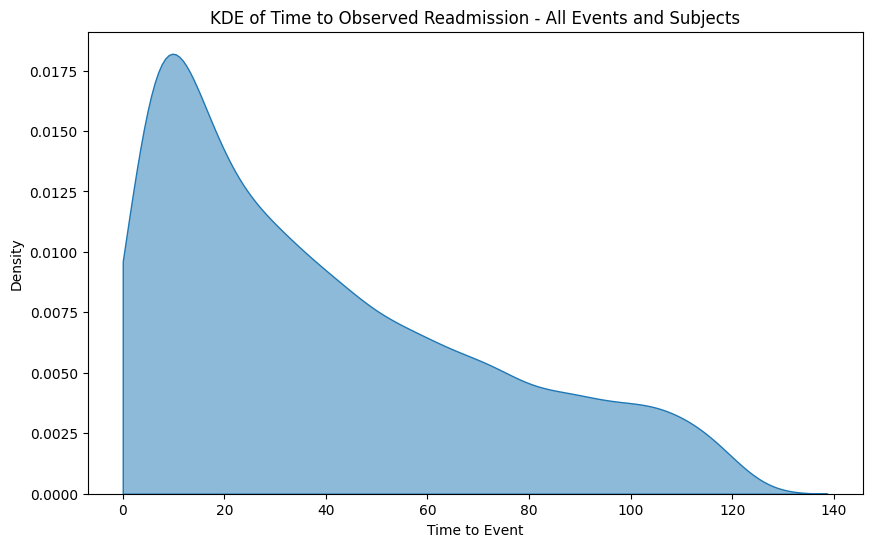

In [37]:
all_observed_readmissions_df = all_events_df[all_events_df["READMISSION_EVENT"] == 1]
plt.figure(figsize=(10, 6))

sns.kdeplot(data=all_observed_readmissions_df, x='EVENT_DURATION', alpha=0.5, fill=True, clip=(0, None))

plt.title('KDE of Time to Observed Readmission - All Events and Subjects')
plt.xlabel('Time to Event')
plt.ylabel('Density')
plt.show()

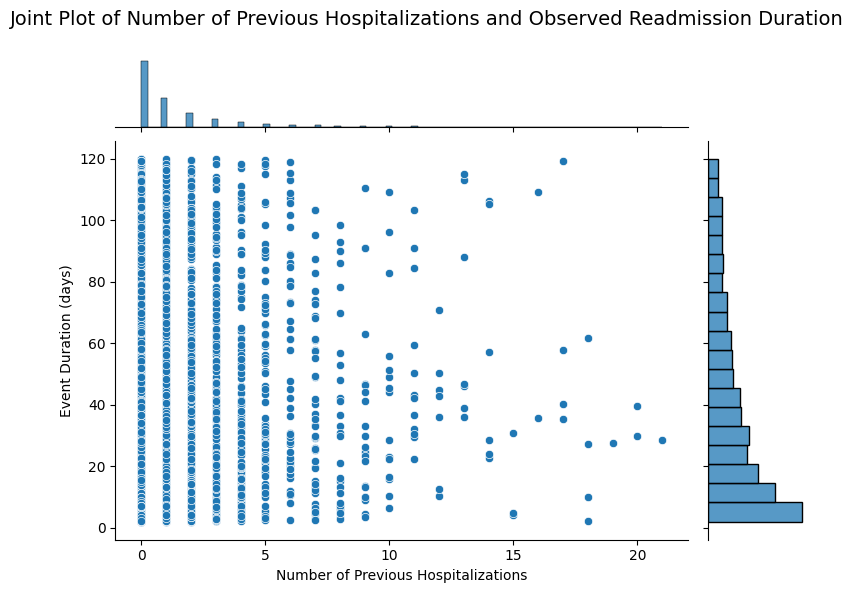

In [38]:
sns.jointplot(
    data=all_observed_readmissions_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    y='EVENT_DURATION',
)
plt.gcf().set_size_inches(8, 6)
plt.suptitle('Joint Plot of Number of Previous Hospitalizations and Observed Readmission Duration', fontsize=14)
plt.subplots_adjust(top=0.9)
plt.xlabel('Number of Previous Hospitalizations')
plt.ylabel('Event Duration (days)')
plt.show()

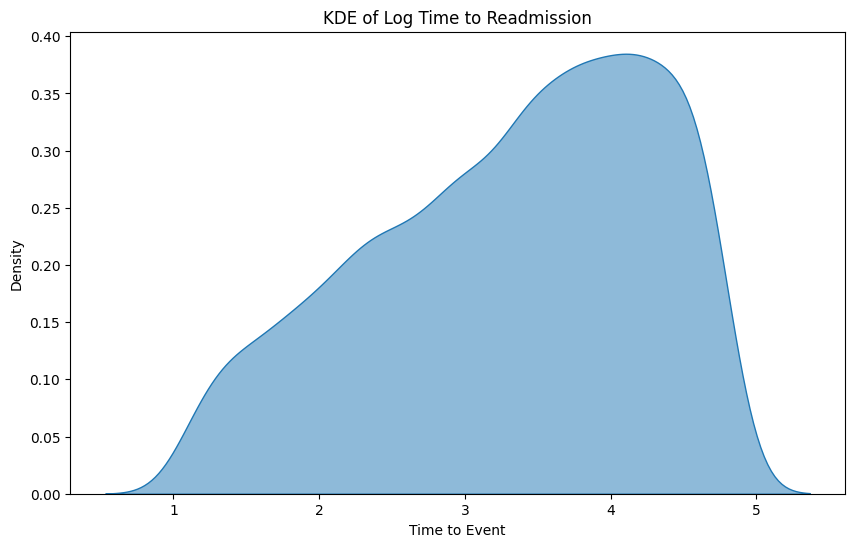

In [39]:
log_duration_readmission_s = np.log1p(all_observed_readmissions_df['EVENT_DURATION'])
plt.figure(figsize=(10, 6))

sns.kdeplot(data=log_duration_readmission_s, alpha=0.5, fill=True)

plt.title('KDE of Log Time to Readmission')
plt.xlabel('Time to Event')
plt.ylabel('Density')
plt.show()

In [40]:
from scipy.stats import normaltest, shapiro
stat_normaltest, p_normaltest = normaltest(log_duration_readmission_s)  # D’Agostino and Pearson’s test
stat_shapiro, p_shapiro = shapiro(log_duration_readmission_s)           # Shapiro-Wilk test

print(f"Normaltest p-value: {p_normaltest}")
print(f"Shapiro-Wilk p-value: {p_shapiro}")

Normaltest p-value: 1.5652308882633818e-94
Shapiro-Wilk p-value: 5.997590858207519e-32


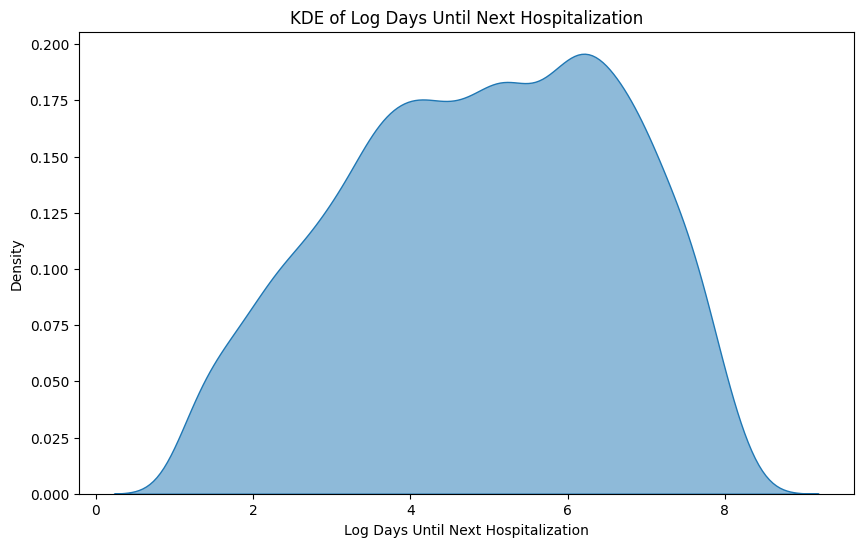

In [41]:
all_events_time_until_next_hosp_df = all_events_df[all_events_df["LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION"].notna()]
plt.figure(figsize=(10, 6))
sns.kdeplot(data=all_events_time_until_next_hosp_df, alpha=0.5, fill=True, x='LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION')
plt.title('KDE of Log Days Until Next Hospitalization')
plt.xlabel('Log Days Until Next Hospitalization')
plt.ylabel('Density')
plt.show()

In [42]:
log_days_until_next_hospitalization_s = all_events_time_until_next_hosp_df["LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION"]

--- Fit Comparison for Log Days Until Next Hospitalization ---


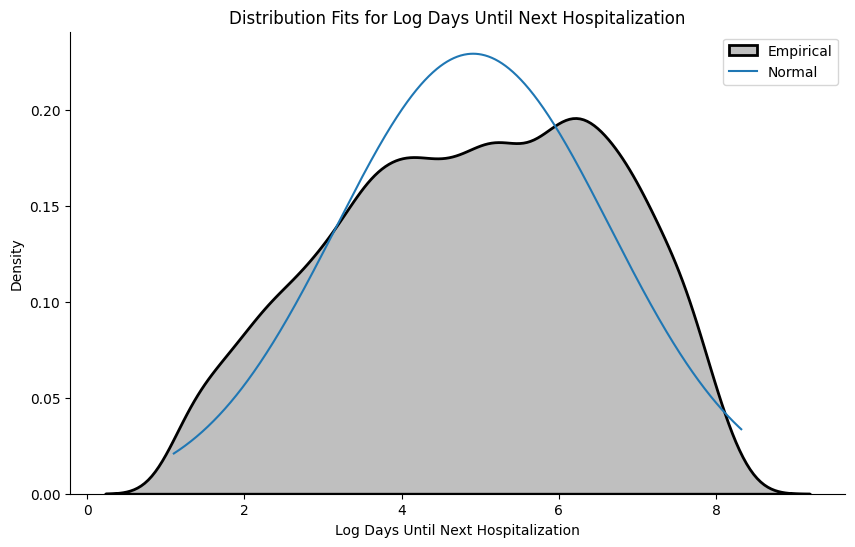

aic           bic        loglik   ks_stat ks_pvalue
normal  30362.246244  30376.142376 -15179.123122  0.053705       0.0

In [43]:
compare_distributions(log_days_until_next_hospitalization_s, 
                      [DistributionType.NORMAL],
                      var_name="Log Days Until Next Hospitalization")

In [44]:
from scipy.stats import normaltest, shapiro
stat_normaltest, p_normaltest = normaltest(log_days_until_next_hospitalization_s)  # D’Agostino and Pearson’s test
stat_shapiro, p_shapiro = shapiro(log_days_until_next_hospitalization_s)           # Shapiro-Wilk test

print(f"Normaltest p-value: {p_normaltest}")
print(f"Shapiro-Wilk p-value: {p_shapiro}")

Normaltest p-value: 3.791233584277224e-236
Shapiro-Wilk p-value: 4.573782835909794e-34


/workspaces/master-thesis-recurrent-health-events-prediction/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7693.



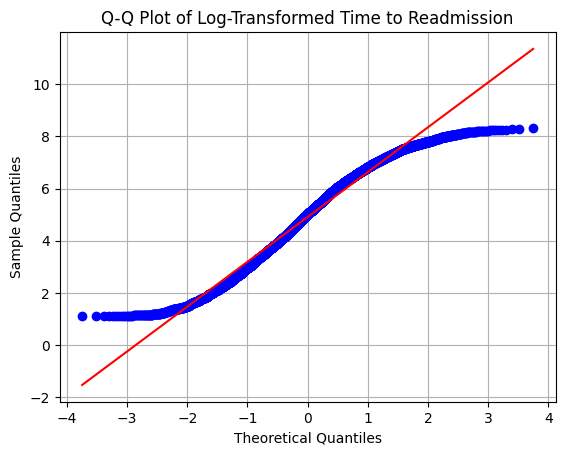

In [45]:
import scipy.stats as stats

stats.probplot(log_days_until_next_hospitalization_s, dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Transformed Time to Readmission")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

### Distribution of Number of Previous Events

In [46]:
count_all_events_per_subject_df = all_events_df.groupby('SUBJECT_ID').agg(TOTAL_NUM_HOSPITALIZATIONS=('HADM_ID', 'nunique')).reset_index()

In [47]:
fig = px.histogram(count_all_events_per_subject_df,
             x='TOTAL_NUM_HOSPITALIZATIONS',
             title='Distribution of Total Number of Hospitalizations per Patient',
             color_discrete_sequence=[px.colors.qualitative.Plotly[0]], width=800)
fig.update_layout(
    xaxis_title='Total Number of Hospitalizations',
    yaxis_title='Count',
    bargap=0.2,
    xaxis=dict(tickmode='linear', dtick=1),
)
fig.show()

In [48]:
event_type_proportions_df = all_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts(normalize=True).rename('Proportion').reset_index()
event_type_counts_df = all_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts().rename('Total Number Events').reset_index()

event_type_proportions_df = event_type_proportions_df.merge(event_type_counts_df, on=('NUM_PREV_HOSPITALIZATIONS', 'EVENT_TYPE'))

fig = px.bar(
       event_type_proportions_df,
       x='NUM_PREV_HOSPITALIZATIONS',
       y='Proportion',
       color='EVENT_TYPE',
       title='Proportion of Event Types by Number of Previous Hospitalizations',
       labels={'Proportion': 'Proportion of Event Type', 'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'EVENT_TYPE': 'Event Type'},
       color_discrete_map=event_type_color_map,
       text='Total Number Events'  # Add text annotations
)
fig.update_layout(
    height=500,
    bargap=0.2,
    xaxis=dict(tickmode='linear', dtick=1)
)

fig.show()


## Last Events

In [20]:
print("Number of subjects: ", last_events_df["SUBJECT_ID"].nunique())
print("Number of events: ", len(last_events_df))

Number of subjects:  9209
Number of events:  9209


### Distribution of Admisison Type

In [21]:
px.pie(
    last_events_df,
    names="ADMISSION_TYPE",
    title=f"Admission Type Proportions",
    labels={"ADMISSION_TYPE": "Admission Type"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600
).show()

### Distribution of Readmission Time Category

In [51]:
px.pie(
    last_events_df,
    names="READMISSION_TIME_CAT",
    title="Distribution of Readmission Time Categories (Days)",
    labels={"READMISSION_TIME_CAT": "Readmission Time Category"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600,
).show()

### Events Types

In [52]:
event_type_proportions_df = last_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts(normalize=True).rename('Proportion').reset_index()
event_type_counts_df = last_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts().rename('Total Number Events').reset_index()

event_type_proportions_df = event_type_proportions_df.merge(event_type_counts_df, on=('NUM_PREV_HOSPITALIZATIONS', 'EVENT_TYPE'))

fig = px.bar(
       event_type_proportions_df,
       x='NUM_PREV_HOSPITALIZATIONS',
       y='Proportion',
       color='EVENT_TYPE',
       title='Proportion of Event Types by Number of Previous Hospitalizations',
       labels={'Proportion': 'Proportion', 'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'EVENT_TYPE': 'Event Type'},
       category_orders={'EVENT_TYPE': ['Readmission after Discharge', 'No Readmission or No Death after Discharge']},
       color_discrete_map=event_type_color_map,
       text='Total Number Events'  # Add text annotations
)
fig.update_layout(height=500, bargap=0.2,
    xaxis=dict(tickmode='linear', dtick=1))  # Position the text at the top of the bars

fig.show()

In [53]:
fig = px.histogram(
    data_frame=last_events_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    color='EVENT_TYPE',
    title='Distribution of Number of Previous Hospitalizations by Event Type',
    color_discrete_map=event_type_color_map,
    barmode='group'
)
fig.show()

### Number of Previous Events

In [62]:
last_events_prev_hosp_per_patient_df = last_events_df.groupby('SUBJECT_ID').first().reset_index()[['SUBJECT_ID', 'NUM_PREV_HOSPITALIZATIONS', 'READMISSION_EVENT']]
value_counts_df = last_events_prev_hosp_per_patient_df[['NUM_PREV_HOSPITALIZATIONS', 'READMISSION_EVENT']].value_counts().reset_index()
last_events_prev_hosp_per_patient_df["label"] = np.where(last_events_prev_hosp_per_patient_df['READMISSION_EVENT'] == 1, 'Readmission within 120 Days', 'No Readmission within 120 Days')
fig = px.histogram(
    last_events_prev_hosp_per_patient_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    facet_col='label',
    title='Count of Num. Prev. Hosp. before Last Readmissions Events',
    labels={'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'label': ''},
    width=800,
    height=400,
    color_discrete_sequence=px.colors.qualitative.Plotly,
)
fig.update_layout(
    yaxis_title='Count',
    bargap=0.05,
)

# Remove '=' from subplot titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
fig.for_each_yaxis(lambda yaxis: yaxis.update(dtick=1000))
fig.for_each_xaxis(lambda xaxis: xaxis.update(dtick=2))


fig.show()

### Diseases at Last Readmissions Events

In [55]:
fig = px.histogram(last_events_df, x='NUM_COMORBIDITIES', title='Distribution of Number of Comorbidities - Last Readmission Events', width=800, height=400, nbins=50)
fig.update_layout(xaxis_title='Number of Comorbidities', yaxis_title='Count')
fig.show()

In [56]:
diseases_last_readmissions_df = last_events_df[['SUBJECT_ID', 'TYPES_COMORBIDITIES']].copy()
diseases_last_readmissions_df.head()

SUBJECT_ID                                TYPES_COMORBIDITIES
0          21  ['other', 'renal_disease', 'congestive_heart_f...
1          26  ['other', 'congestive_heart_failure', 'myocard...
2          28  ['other', 'diabetes_without_cc', 'chronic_pulm...
3          30              ['other', 'congestive_heart_failure']
4          32             ['other', 'chronic_pulmonary_disease']

In [57]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# If your column is still strings, convert to list first
diseases_last_readmissions_df['TYPES_COMORBIDITIES'] = diseases_last_readmissions_df['TYPES_COMORBIDITIES'].apply(ast.literal_eval)

# Now one-hot encode the comorbidities
mlb = MultiLabelBinarizer()
disease_ohe = mlb.fit_transform(diseases_last_readmissions_df['TYPES_COMORBIDITIES'])

# Create a DataFrame with patient IDs as index and disease columns
disease_df = pd.DataFrame(disease_ohe, 
                          columns=mlb.classes_, 
                          index=diseases_last_readmissions_df['SUBJECT_ID'])

# Now you can see the matrix you described
disease_df.head()

aids  cerebrovascular_disease  chronic_pulmonary_disease  \
SUBJECT_ID                                                             
21             0                        1                          0   
26             0                        0                          0   
28             0                        0                          1   
30             0                        0                          0   
32             0                        0                          1   

            congestive_heart_failure  dementia  diabetes_with_cc  \
SUBJECT_ID                                                         
21                                 1         0                 0   
26                                 1         0                 0   
28                                 0         0                 0   
30                                 1         0                 0   
32                                 0         0                 0   

            diabetes_without_cc  malignant_cancer  metastatic_solid_tumor  \
SUBJECT_ID                                                                  
21                            1                 0                       0   
26                            0                 0                       0   
28                            1                 0                       0   
30                            0                 0                       0   
32                            0                 0                       0   

            mild_liver_disease  myocardial_infarct  other  paraplegia  \
SUBJECT_ID                                                              
21                           0                   1      1           0   
26                           0                   1      1           0   
28                           0                   1      1           0   
30                           0                   0      1           0   
32                           0                   0      1           0   

            peptic_ulcer_disease  peripheral_vascular_disease  renal_disease  \
SUBJECT_ID                                                                     
21                             0                            0              1   
26                             0                            0              0   
28                             0                            0              0   
30                             0                            0              0   
32                             0                            0              0   

            rheumatic_disease  severe_liver_disease  
SUBJECT_ID                                           
21                          0                     0  
26                          0                     0  
28                          0                     0  
30                          0                     0  
32                          0                     0

In [58]:
disease_counts = disease_df.sum().sort_values(ascending=False)

px.bar(disease_counts,
    title='Total Number of Patients with Each Disease - Last Readmissions Events',
    labels={'index': 'Disease', 'value': 'Number of Patients'},
    width=1200,
    height=400
).update_layout(xaxis_title='Disease', yaxis_title='Number of Patients').show()


In [59]:
diseases_counts_df = disease_counts.reset_index().rename(columns={'index': 'Disease', 0: 'Number of Patients'})
diseases_counts_df['Percent of Patients'] = diseases_counts_df['Number of Patients'] / diseases_last_readmissions_df['SUBJECT_ID'].nunique() * 100
diseases_counts_df

Disease  Number of Patients  Percent of Patients
0                         other               11598            99.862235
1      congestive_heart_failure                6797            58.524195
2     chronic_pulmonary_disease                6028            51.902876
3           diabetes_without_cc                3082            26.536938
4            myocardial_infarct                2661            22.912003
5                 renal_disease                2158            18.581023
6   peripheral_vascular_disease                1489            12.820734
7       cerebrovascular_disease                1128             9.712416
8              malignant_cancer                 941             8.102290
9            mild_liver_disease                 806             6.939900
10             diabetes_with_cc                 804             6.922680
11            rheumatic_disease                 382             3.289134
12       metastatic_solid_tumor                 319             2.746685
13         peptic_ulcer_disease                 263             2.264508
14         severe_liver_disease                 220             1.894266
15                   paraplegia                 209             1.799552
16                         aids                  78             0.671603
17                     dementia                  55             0.473566

## Historical Events EDA

In [60]:
events_count = historical_events_df.groupby('SUBJECT_ID').size().reset_index(name='EVENT_COUNT')

# Group by Event Count and count the number of patients
event_count_distribution = events_count['EVENT_COUNT'].value_counts().sort_index()

# Plot the bar chart with all ticks on the x-axis
fig = px.bar(
    event_count_distribution,
    x=event_count_distribution.index,
    y=event_count_distribution.values,
    labels={'x': 'Event Count', 'y': 'Number of Patients'},
    title='Distribution of Event Count per Patient',
    width=800,
    height=400
)
fig.update_layout(
    xaxis_title='Event Count',
    yaxis_title='Number of Patients',
    xaxis=dict(tickmode='linear', dtick=1)  # Ensure all ticks are displayed
)
fig.show()